#### This notebook tests the noise-corrected correlation formula on simulated crowding thresholds and reading speeds.
Created Jan 13, 2025  //  Last updated Feb 3, 2025

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import pearsonr, norm

Below I load in some data to help inform simulation parameters.

In [2]:
# # Data from pre-VSS experiment
# df = pd.read_csv('/users/annabruns/Documents/~NYU/Research/Crowding/Results/correlation/crowdingReadingAcuity_dec24_cleaned.csv').iloc[:,1:]
# df['crowding_L5_var'] = np.var(df[['crowding_L5_test', 'crowding_L5_retest']], axis=1)
# df['crowding_R5_var'] = np.var(df[['crowding_R5_test', 'crowding_R5_retest']], axis=1)

In [3]:
# x = df['crowding']
# y = df['rsvp']

# print("crowding mean across observers (log deg):", np.mean(x).round(4))
# print("crowding variance across observers (log deg):", np.round(np.var(x),4))
# print("rsvp mean across observers (log w/m):", np.mean(y).round(4))
# print("rsvp variance across observers (log w/m):", np.round(np.var(y),4))
# print("crowding x reading correlation:", pearsonr(x, y))

Below is data Helen sent on Feb 3 to inform mean crowding threshold and learning factor.

Text(0.5, 1.0, "Helen's data")

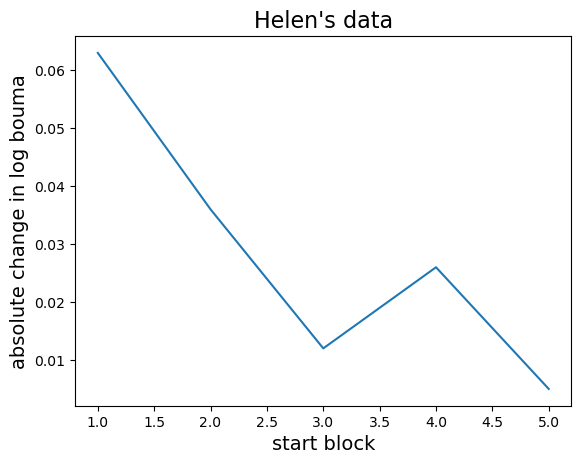

In [4]:
# latest crowding means by block (log bouma)
crowding_thresh = np.array([-0.426, -0.489, -0.525, -0.537, -0.563, -0.568])
crowding_thresh_changes = np.array([np.abs(crowding_thresh[1] - crowding_thresh[0]), 
                                    np.abs(crowding_thresh[2] - crowding_thresh[1]),
                                    np.abs(crowding_thresh[3] - crowding_thresh[2]),
                                    np.abs(crowding_thresh[4] - crowding_thresh[3]),
                                    np.abs(crowding_thresh[5] - crowding_thresh[4])])
plt.plot(np.arange(1,6), crowding_thresh_changes)
plt.xlabel('start block', size=14)
plt.ylabel('absolute change in log bouma', size=14)
plt.title('Helen\'s data', size=16)

In [5]:
crowding_thresh_changes

array([0.063, 0.036, 0.012, 0.026, 0.005])

In [6]:
def simulate_psychophysics_data(n_samples=100, n_measurements=6, correlation = -0.7, crowding_ObsVar = 0.022, 
                                crowding_MeasVar = 0.012, crowding_Mean = -0.426, crowding_learning_factor = 0.06,
                                rsvp_ObsVar = 0.029, rsvp_MeasVar = 0.015, rsvp_Mean = 2.96, 
                                rsvp_learning_factor = 0):
    '''
    Simulates crowding (log Bouma factors) and RSVP reading (log words/min) data
    for specified number of samples and measurements per sample for each task
    
    Returns dataframe containing: the ground truth threshold for each task/participant, each measurement, 
    and the mean of those measurements for each "participant" (sample)
    
    # Parameters for the simulation
    # CROWDING (8 deg eccentricity)
    crowding_ObsVar = 0.022         # Variance across observers
    crowding_MeasVar = 0.012        # Variance of measurement
    crowding_Mean = -0.426          # Mean threshold for block 1 (log Bouma)
    crowding_learning_factor = 0.06 # Reduction in crowding threshold from measurement 1 to 2

    # RSVP READING (foveal)
    rsvp_ObsVar = 0.029             # Variance across observers
    rsvp_MeasVar = 0.015            # Variance of measurement
    rsvp_Mean = 2.96                # Mean reading speed (log words/minute)
    rsvp_learning_factor = 0        # Reduction in crowding threshold from measurement 1 to 2

    # Correlation between crowding and RSVP reading
    correlation = -0.7
    '''

    # Covariance matrix for the "true" thresholds
    cov_matrix = np.array([
        [crowding_ObsVar, correlation * np.sqrt(crowding_ObsVar * rsvp_ObsVar)],
        [correlation * np.sqrt(crowding_ObsVar * rsvp_ObsVar), rsvp_ObsVar]
    ])

    # Simulate "true" thresholds for crowding and RSVP reading
    true_thresholds = np.random.multivariate_normal(
        mean=[crowding_Mean, rsvp_Mean],
        cov=cov_matrix,
        size=n_samples
    )

    # Extract "true" values for crowding and RSVP
    true_crowding = true_thresholds[:, 0]
    true_rsvp = true_thresholds[:, 1]

    # Initialize a dictionary to store measurements
    data = {
        'crowding_true': true_crowding,
        'rsvp_true': true_rsvp,
    }

    # Simulate noisy measurements for both tasks in a single loop
    # Account for learning in crowding task 
    crowding_measurements = []
    rsvp_measurements = []
    for i in range(n_measurements):
        crowding_noise = np.random.normal(0, np.sqrt(crowding_MeasVar), size=n_samples)
        rsvp_noise = np.random.normal(0, np.sqrt(rsvp_MeasVar), size=n_samples)
        
        # Calculate noisy measurements 
        crowding_measurement = true_crowding + crowding_noise
        rsvp_measurement = true_rsvp + rsvp_noise
        
        # Reduce crowding thresholds by learning factor
        if i > 0:
            crowding_measurement -= sum(crowding_learning_factor / j for j in range(1, i + 1))
            rsvp_measurement -= sum(rsvp_learning_factor / j for j in range(1, i + 1))

        # Add individual measurements to the dictionary
        data[f'crowding_measurement{i+1}'] = crowding_measurement
        data[f'rsvp_measurement{i+1}'] = rsvp_measurement

        # Collect measurements for later averaging
        crowding_measurements.append(crowding_measurement)
        rsvp_measurements.append(rsvp_measurement)

    # Compute the averages of all measurements
    data['crowding_measurement'] = np.mean(crowding_measurements, axis=0)
    data['rsvp_measurement'] = np.mean(rsvp_measurements, axis=0)

    # Create and return the DataFrame
    simulation_data = pd.DataFrame(data)
    return simulation_data

In [44]:
simulation_data = simulate_psychophysics_data(n_samples=200, n_measurements=2)
simulation_data = simulation_data[sorted(simulation_data.columns)]
simulation_data.head()

,crowding_measurement,crowding_measurement1,crowding_measurement2,crowding_true,rsvp_measurement,rsvp_measurement1,rsvp_measurement2,rsvp_true
0,-0.649889,-0.751896,-0.547882,-0.751586,3.315944,3.388525,3.243364,3.256311
1,-0.775571,-0.645474,-0.905668,-0.723683,3.183534,3.181648,3.185421,3.220149
2,-0.591457,-0.626009,-0.556906,-0.468476,2.970877,3.053931,2.887823,2.864395
3,-0.391955,-0.263510,-0.520401,-0.391088,3.120344,3.176333,3.064355,3.074071
4,-0.466735,-0.287795,-0.645676,-0.496058,3.068012,3.087066,3.048958,3.151494


In [16]:
test = simulate_psychophysics_data(n_samples=100, n_measurements=2)
test.head()

,crowding_true,rsvp_true,crowding_measurement1,rsvp_measurement1,crowding_measurement2,rsvp_measurement2,crowding_measurement,rsvp_measurement
0,-0.503177,2.845528,-0.595548,2.988387,-0.548413,2.734648,-0.571981,2.861517
1,-0.660886,3.046720,-0.652706,3.013161,-0.805148,3.016044,-0.728927,3.014603
2,-0.628709,3.017207,-0.622484,3.169154,-0.643344,3.175629,-0.632914,3.172391
3,-0.380662,2.851064,-0.344322,2.757737,-0.344238,2.784406,-0.344280,2.771072
4,-0.211441,2.823311,-0.054742,2.921592,-0.190763,2.799121,-0.122752,2.860356


NameError: name 'ax' is not defined

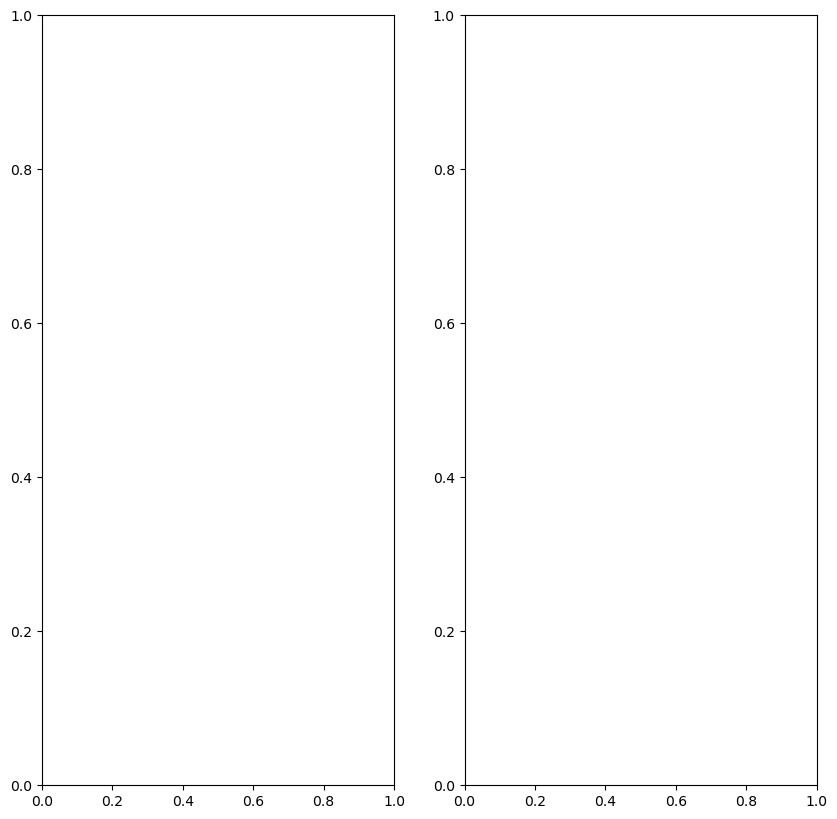

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# Scatter plot
ax.scatter(x, y, alpha=0.7)

# Regression line
# UPDATE TO MINIMIZE PRODUCT OF X AND Y RESIDUALS
slope, intercept = np.polyfit(x, y, 1)
x_vals = np.linspace(min(x), max(x), 100)
y_vals = slope * x_vals + intercept
ax.plot(x_vals, y_vals, color='red', linestyle='dashed', label='Trend line')

# Pearson correlation
r, _ = stats.pearsonr(x, y)
ax.text(0.05, 1.05, f'Pearson r = {r:.2f}', transform=ax.transAxes, fontsize=14, color='red')

# Labels and title
ax.set_xlabel(x_name, fontsize=14)
ax.set_ylabel(y_name, fontsize=14)
if title:
    ax.set_title(title)

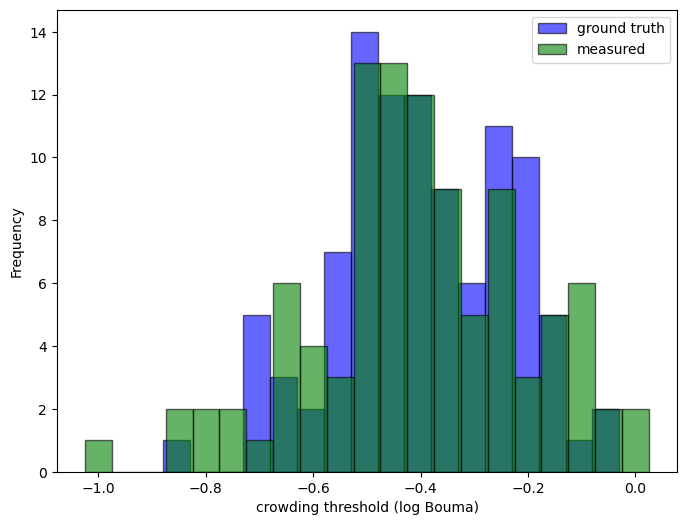

In [18]:
bin_width = 0.05

plt.figure(figsize=(8, 6))
plt.hist(simulation_data['crowding_true'], 
         bins=np.arange(min(simulation_data['crowding_true']), 
                        max(simulation_data['crowding_true']) + bin_width, bin_width), 
         color='blue', alpha=0.6, label='ground truth', edgecolor='black')
plt.hist(simulation_data['crowding_measurement1'], 
         bins=np.arange(min(simulation_data['crowding_measurement1']), 
                        max(simulation_data['crowding_measurement1']) + bin_width, bin_width), 
         color='green', alpha=0.6, label='measured', edgecolor='black')
plt.xlabel('crowding threshold (log Bouma)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Text(0.5, 1.0, 'simulated')

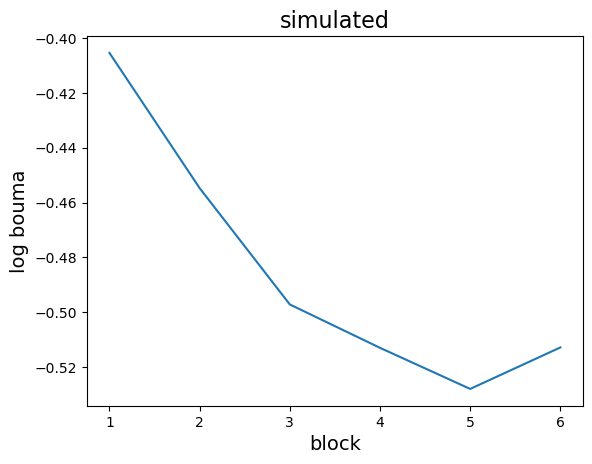

In [19]:
mean_across_participants = np.array(np.mean(simulation_data, axis = 0))

plt.plot(np.arange(1,7), mean_across_participants[1:7])
plt.xlabel('block', size=14)
plt.ylabel('log bouma', size=14)
plt.title('simulated', size=16)

Below are some measurement pooling options we can compare:
1. mean of thresholds 1-4, 1-6, 2-5, 2-6
2. mean of thresholds 1 and 2 / 3 and 4
3. mean of thresholds 1 and 2 / 3 and 4 / 5 and 6
4. mean of thresholds 1 and 3 / 2 and 4
5. mean of thresholds 2 and 4 / 3 and 5

For each pooling method, we compute:
1. the average variance across measurements and within participants (noise)
2. the average variance across participants and within measurements (signal)
3. the noise-adjusted correlation using the formula derived below

We pick the pooling method that best approximates the true correlation between crowding and reading (-0.7). We repeat this for different numbers of participants.

In [20]:
# CROWDING
# add means to simulation_data dataframe

simulation_data['crowding_mean12'] = (simulation_data['crowding_measurement1'] + 
                                      simulation_data['crowding_measurement2']) / 2

simulation_data['crowding_mean13'] = (simulation_data['crowding_measurement1'] + 
                                      simulation_data['crowding_measurement3']) / 2

simulation_data['crowding_mean24'] = (simulation_data['crowding_measurement2'] + 
                                      simulation_data['crowding_measurement4']) / 2

simulation_data['crowding_mean34'] = (simulation_data['crowding_measurement3'] + 
                                      simulation_data['crowding_measurement4']) / 2

simulation_data['crowding_mean35'] = (simulation_data['crowding_measurement3'] + 
                                      simulation_data['crowding_measurement5']) / 2

simulation_data['crowding_mean56'] = (simulation_data['crowding_measurement5'] + 
                                      simulation_data['crowding_measurement6']) / 2

In [21]:
# CROWDING
# define new dataframes containing different pooling options, for testing

crowding_1thru4 = simulation_data[['crowding_measurement1', 'crowding_measurement2', 'crowding_measurement3',
                                   'crowding_measurement4']]

crowding_1thru6 = simulation_data[['crowding_measurement1', 'crowding_measurement2', 'crowding_measurement3',
                                   'crowding_measurement4', 'crowding_measurement5', 'crowding_measurement6']] 

crowding_2thru5 = simulation_data[['crowding_measurement2', 'crowding_measurement3', 'crowding_measurement4', 
                                   'crowding_measurement5']] 

crowding_2thru6 = simulation_data[['crowding_measurement2', 'crowding_measurement3', 'crowding_measurement4', 
                                   'crowding_measurement5', 'crowding_measurement6']] 

crowding_12and34 = simulation_data[['crowding_mean12', 'crowding_mean34']] 

crowding_12and34and56 = simulation_data[['crowding_mean12', 'crowding_mean34', 'crowding_mean56']]

crowding_13and24 = simulation_data[['crowding_mean13', 'crowding_mean24']]

crowding_24and35 = simulation_data[['crowding_mean24', 'crowding_mean35']]

In [22]:
# RSVP
# add means to simulation_data dataframe

simulation_data['rsvp_mean12'] = (simulation_data['rsvp_measurement1'] + 
                                  simulation_data['rsvp_measurement2']) / 2

simulation_data['rsvp_mean13'] = (simulation_data['rsvp_measurement1'] + 
                                  simulation_data['rsvp_measurement3']) / 2

simulation_data['rsvp_mean24'] = (simulation_data['rsvp_measurement2'] + 
                                  simulation_data['rsvp_measurement4']) / 2

simulation_data['rsvp_mean34'] = (simulation_data['rsvp_measurement3'] + 
                                  simulation_data['rsvp_measurement4']) / 2

simulation_data['rsvp_mean35'] = (simulation_data['rsvp_measurement3'] + 
                                  simulation_data['rsvp_measurement5']) / 2

simulation_data['rsvp_mean56'] = (simulation_data['rsvp_measurement5'] + 
                                  simulation_data['rsvp_measurement6']) / 2

In [23]:
# RSVP
# define new dataframes containing different pooling options, for testing

rsvp_1thru4 = simulation_data[['rsvp_measurement1', 'rsvp_measurement2', 'rsvp_measurement3',
                                   'rsvp_measurement4']]

rsvp_1thru6 = simulation_data[['rsvp_measurement1', 'rsvp_measurement2', 'rsvp_measurement3',
                                'rsvp_measurement4', 'rsvp_measurement5', 'rsvp_measurement6']] 

rsvp_2thru5 = simulation_data[['rsvp_measurement2', 'rsvp_measurement3', 'rsvp_measurement4', 
                                   'rsvp_measurement5']] 

rsvp_2thru6 = simulation_data[['rsvp_measurement2', 'rsvp_measurement3', 'rsvp_measurement4', 
                                   'rsvp_measurement5', 'rsvp_measurement6']] 

rsvp_12and34 = simulation_data[['rsvp_mean12', 'rsvp_mean34']] 

rsvp_12and34and56 = simulation_data[['rsvp_mean12', 'rsvp_mean34', 'rsvp_mean56']]

rsvp_13and24 = simulation_data[['rsvp_mean13', 'rsvp_mean24']]

rsvp_24and35 = simulation_data[['rsvp_mean24', 'rsvp_mean35']]

## Functions for noise-correction

In [24]:
def compute_variances(data):
    '''
    takes in n x m dataframe representing n participants and m thresholds (log units)
    
    returns within-participant and across-participant variances
    '''
    
    # Noise: variance within individuals
    within_indiv_var = np.mean(np.var(data, axis = 1, ddof=1))

    # Signal: variance across individuals
    across_indiv_var = np.var(np.mean(data, axis = 1), ddof=1)
    
    return within_indiv_var, across_indiv_var

In [25]:
def perform_noise_correction(x, y):
    '''
    Denis/Anna formula (not quite right)
    
    applies noise-correction procedure outlined below to x and y
    
    inputs: two dataframes, each n x m, n participants and m thresholds (log units)
    
    returns: measured correlation of x and y (means across measurements for each participant)
    and noise-corrected correlation
    '''
    
    # Compute within and across individual variances for each variable
    x_within_indiv_var, x_across_indiv_var = compute_variances(x)
    y_within_indiv_var, y_across_indiv_var = compute_variances(y)
    
    # Noise-correct the across-indiv variances
    varX = x_across_indiv_var - x_within_indiv_var
    varY = y_across_indiv_var - y_within_indiv_var
    
    # Compute noise-to-signal ratios
    varM = x_within_indiv_var
    varN = y_within_indiv_var
    rX = varM / varX
    rY = varN / varY
    
    # Compute measured correlation of x and y (means across measurements for each participant)
    measured_corr, _ = pearsonr(np.mean(x, axis=1), np.mean(y, axis=1))

    # Compute noise-corrected correlation
    corrected_corr = measured_corr * np.sqrt((1 + rX) * (1 + rY))

    return measured_corr.round(4), corrected_corr.round(4)

In [26]:
def compute_noise_ceiling(measurements):
    """
    Reference: Diedrichsen
    Computes the noise ceiling for a set of repeated measurements.
    Uses split-half reliability across multiple measurements and the geometric mean formula.
    """
    n_measurements = measurements.shape[1]
    
    first_half = measurements.iloc[:, :n_measurements//2]
    last_half = measurements.iloc[:, n_measurements//2:]
    odd_half = measurements.iloc[:, 1::2]
    even_half = measurements.iloc[:, 0::2]
    
    r_firstLast, _ = pearsonr(np.mean(first_half, axis=1), np.mean(last_half, axis=1))
    r_oddEven, _ = pearsonr(np.mean(odd_half, axis=1), np.mean(even_half, axis=1))

    # Compute the split-half reliability as the geometric mean
    r_i = np.sqrt(r_firstLast * r_oddEven)

    # Apply the extrapolation formula for multiple measurements
    N = 2
    r_m = (N * r_i) / ((r_i * (N - 1)) + 1)

    return r_m

In [27]:
# Jitter function to slightly shift x-values for better visibility
def jitter(values, jitter_amount=0.05):
    return values + np.random.uniform(-jitter_amount, jitter_amount, size=len(values))

## Simulate for various sample sizes and num measurements
## Compute difference between measured/corrected corr – true corr

Below we run the simulation 1,000 times for each combo of specified sample sizes and number of measurements. For each round we get the mean difference between the ground truth corr and the corrected corr (using Diedrichsen's noise ceiling method). Then we can plot resulting histograms.

In [28]:
# Run simulation for different sample sizes and measurement counts
range_samples = [40, 80, 160, 320]
range_measurements = [2, 4, 8, 16]
n_repetitions = 1000
true_correlation = -0.45

# Store results
hist_corrected_corr = {}
hist_measured_corr = {}
results_corr = []

for n_samples in range_samples:
    for n_meas in range_measurements:
        diff_list_measured = []
        diff_list_corrected = []

        for _ in range(n_repetitions):
            simulation_data = simulate_psychophysics_data(n_samples, n_meas, correlation = true_correlation)

            crowding_measurements = simulation_data[[f'crowding_measurement{i+1}' for i in range(n_meas)]]
            rsvp_measurements = simulation_data[[f'rsvp_measurement{i+1}' for i in range(n_meas)]]

            r_ceil_crowding = compute_noise_ceiling(crowding_measurements)
            r_ceil_rsvp = compute_noise_ceiling(rsvp_measurements)
            
            r_ceil = np.sqrt(r_ceil_crowding * r_ceil_rsvp)

            measured_corr, _ = pearsonr(simulation_data['crowding_measurement'], simulation_data['rsvp_measurement'])
            corrected_corr = measured_corr / r_ceil

            diff_list_measured.append(measured_corr - true_correlation)
            diff_list_corrected.append(corrected_corr - true_correlation)
            
        hist_measured_corr[(n_samples, n_meas)] = diff_list_measured
        hist_corrected_corr[(n_samples, n_meas)] = diff_list_corrected
        
        rmse_measured = np.sqrt(np.mean([x**2 for x in diff_list_measured])) 
        rmse_corrected = np.sqrt(np.mean([x**2 for x in diff_list_corrected]))
        
        mean_diff_measured = np.mean(diff_list_measured)
        mean_diff_corrected = np.mean(diff_list_corrected)
        
        sd_measured = np.std(diff_list_measured)
        sd_corrected = np.std(diff_list_corrected)
        
        ci_lower_measured, ci_upper_measured = norm.interval(0.95, loc=mean_diff_measured, 
                                                             scale=np.std(diff_list_measured) / np.sqrt(n_repetitions))
        ci_lower_corrected, ci_upper_corrected = norm.interval(0.95, loc=mean_diff_corrected, 
                                                               scale=np.std(diff_list_corrected) / np.sqrt(n_repetitions))

        results_corr.append({
            "n_samples": n_samples,
            "n_measurements": n_meas,
            
            "meanDiff_measured": mean_diff_measured,
            "rmse_measured": rmse_measured,
            "sd_measured": sd_measured,
            "ciLower_measured": ci_lower_measured,
            "ciUpper_measured": ci_upper_measured,
            
            "meanDiff_corrected": mean_diff_corrected,
            "rmse_corrected": rmse_corrected,
            "sd_corrected": sd_corrected,
            "ciLower_corrected": ci_lower_corrected,
            "ciUpper_corrected": ci_upper_corrected
        })
    
    print("done with n_samples =",n_samples)

results_corr_df = pd.DataFrame(results_corr)

done with n_samples = 40
done with n_samples = 80
done with n_samples = 160
done with n_samples = 320


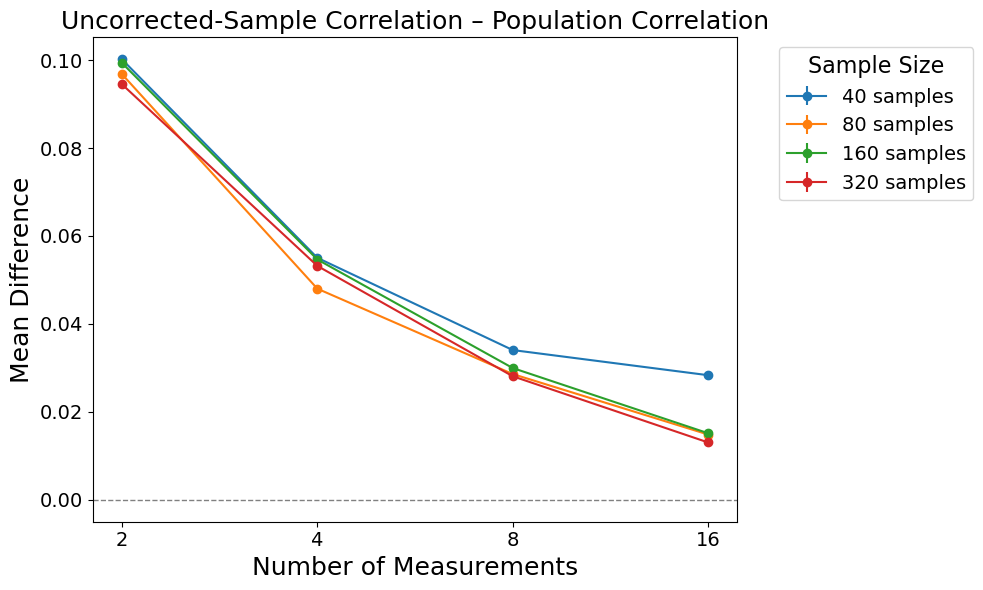

In [29]:
title = "Uncorrected-Sample Correlation – Population Correlation"

plt.figure(figsize=(10, 6))
jitter = 0

for sample_size in results_corr_df["n_samples"].unique():
    #jitter += 0.1
    subset = results_corr_df[results_corr_df["n_samples"] == sample_size]

    plt.errorbar(subset["n_measurements"] + jitter, subset["meanDiff_measured"],
                 yerr=0, #subset["sd_measured"],
                 fmt='-o', label=f"{sample_size} samples")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xticks(size = 14)
plt.xscale('log')
plt.xticks([2, 4, 8, 16], labels=[2, 4, 8, 16], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.yticks(size = 14)
plt.xlabel("Number of Measurements", size = 18)
plt.ylabel("Mean Difference", size = 18)
plt.title(title, size = 18)
plt.legend(title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize = 16, fontsize = 14)

plt.tight_layout()
plt.show()

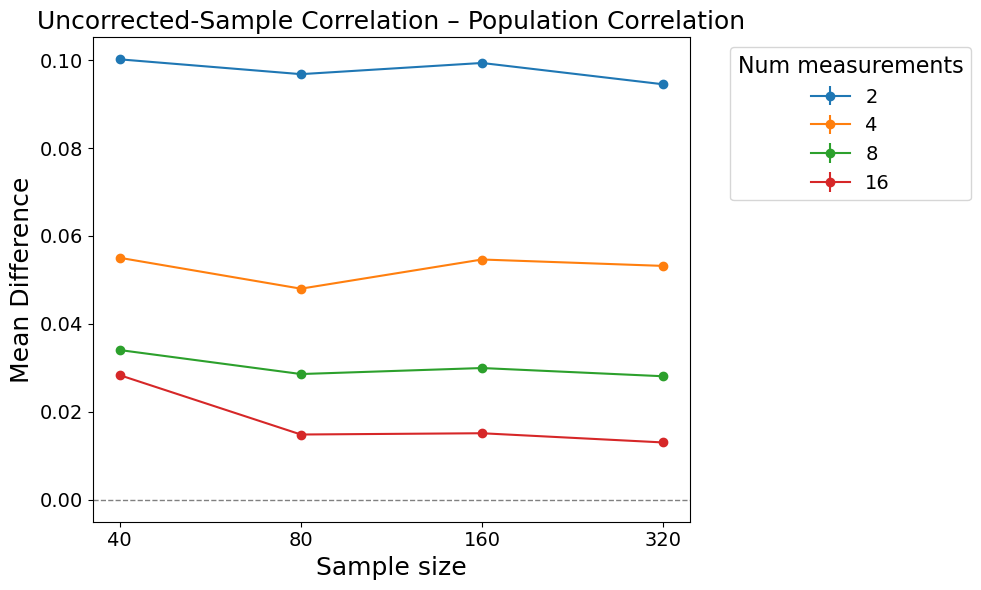

In [30]:
# Line plot
title = "Uncorrected-Sample Correlation – Population Correlation"

plt.figure(figsize=(10, 6))

for n_meas in results_corr_df["n_measurements"].unique():
    subset = results_corr_df[results_corr_df["n_measurements"] == n_meas]

    plt.errorbar(subset["n_samples"], subset["meanDiff_measured"],
                 yerr=0, #subset["sd_measured"],
                 fmt='-o', label=f"{n_meas}")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xscale('log')  # Set log scale for x-axis
plt.xticks([40, 80, 160, 320], labels=[40, 80, 160, 320], size=14)  # Keep specified tick marks
plt.yticks(size = 14)
plt.xlabel("Sample size", size = 18)
plt.ylabel("Mean Difference", size = 18)
plt.title(title, size = 18)
plt.legend(title="Num measurements", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize = 16, fontsize = 14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout()
plt.show()

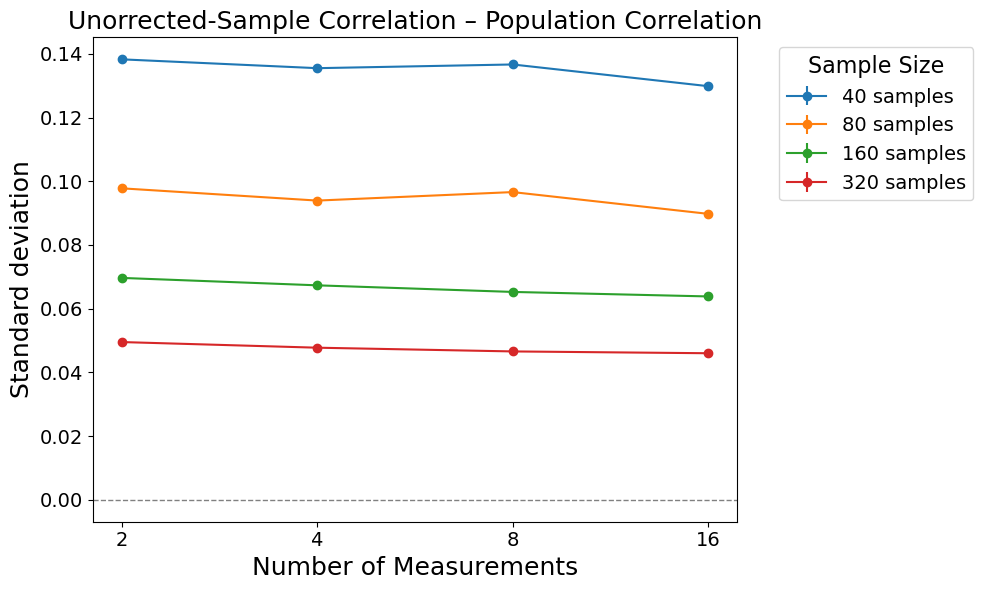

In [31]:
title = "Unorrected-Sample Correlation – Population Correlation"

plt.figure(figsize=(10, 6))
jitter = 0

for sample_size in results_corr_df["n_samples"].unique():
    #jitter += 0.1
    subset = results_corr_df[results_corr_df["n_samples"] == sample_size]

    plt.errorbar(subset["n_measurements"] + jitter, subset["sd_measured"],
                 yerr=0, #subset["sd_measured"],
                 fmt='-o', label=f"{sample_size} samples")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xticks(size = 14)
plt.xscale('log')
plt.xticks([2, 4, 8, 16], labels=[2, 4, 8, 16], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())
plt.yticks(size = 14)
plt.xlabel("Number of Measurements", size = 18)
plt.ylabel("Standard deviation", size = 18)
plt.title(title, size = 18)
plt.legend(title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize = 16, fontsize = 14)

plt.tight_layout()
plt.show()

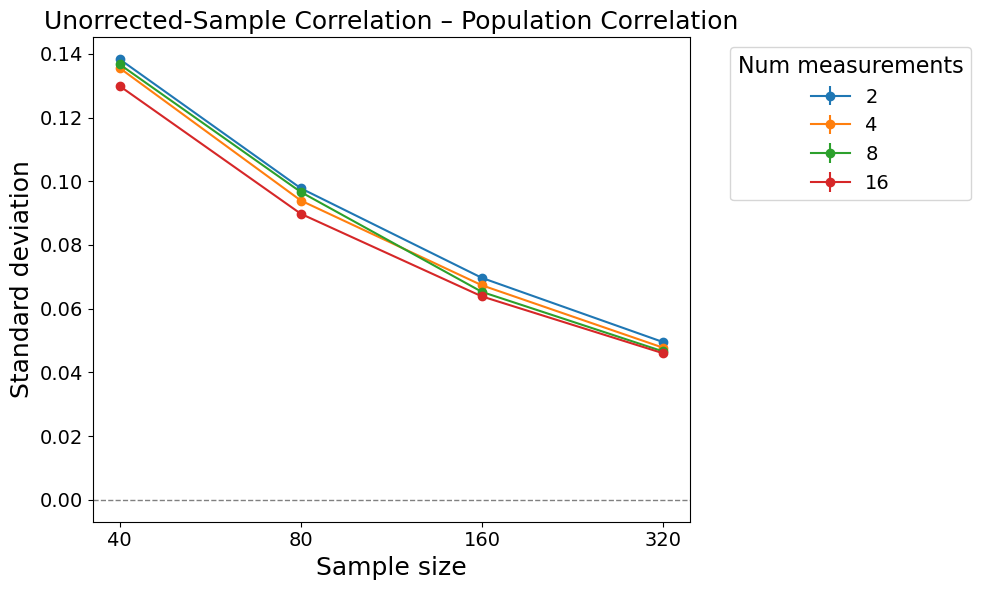

In [32]:
# Line plot
title = "Unorrected-Sample Correlation – Population Correlation"

plt.figure(figsize=(10, 6))

for n_meas in results_corr_df["n_measurements"].unique():
    subset = results_corr_df[results_corr_df["n_measurements"] == n_meas]

    plt.errorbar(subset["n_samples"], subset["sd_measured"],
                 yerr=0, #subset["sd_measured"],
                 fmt='-o', label=f"{n_meas}")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xscale('log')  # Set log scale for x-axis
plt.xticks([40, 80, 160, 320], labels=[40, 80, 160, 320], size=14)  # Keep specified tick marks
plt.yticks(size = 14)
plt.xlabel("Sample size", size = 18)
plt.ylabel("Standard deviation", size = 18)
plt.title(title, size = 18)
plt.legend(title="Num measurements", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize = 16, fontsize = 14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

plt.tight_layout()
plt.show()

## RMSE

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3792280598.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["rmse_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3792280598.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["rmse_corrected"],


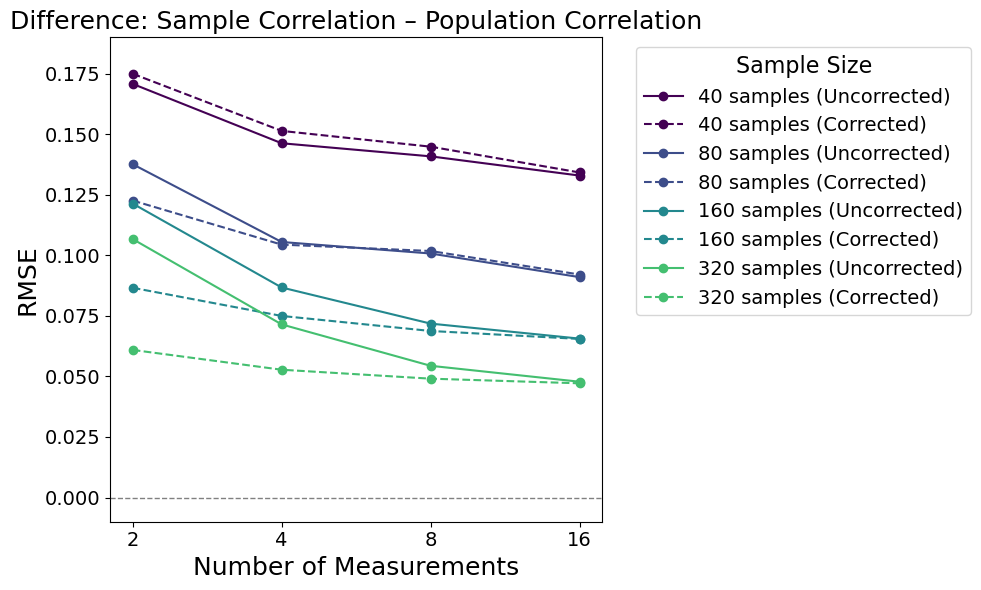

In [33]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors

plt.figure(figsize=(10, 6))

for i, sample_size in enumerate(sample_sizes):
    subset = results_corr_df[results_corr_df["n_samples"] == sample_size]

    color = colors[i]
    plt.errorbar(subset["n_measurements"], subset["rmse_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{sample_size} samples (Uncorrected)")
    plt.errorbar(subset["n_measurements"], subset["rmse_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{sample_size} samples (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.ylim(-.01,0.19)
plt.yticks(size=14)
plt.xlabel("Number of Measurements", size=18)
plt.ylabel("RMSE", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([2, 4, 8, 16], labels=[2, 4, 8, 16], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/1622808128.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["rmse_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/1622808128.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["rmse_corrected"],


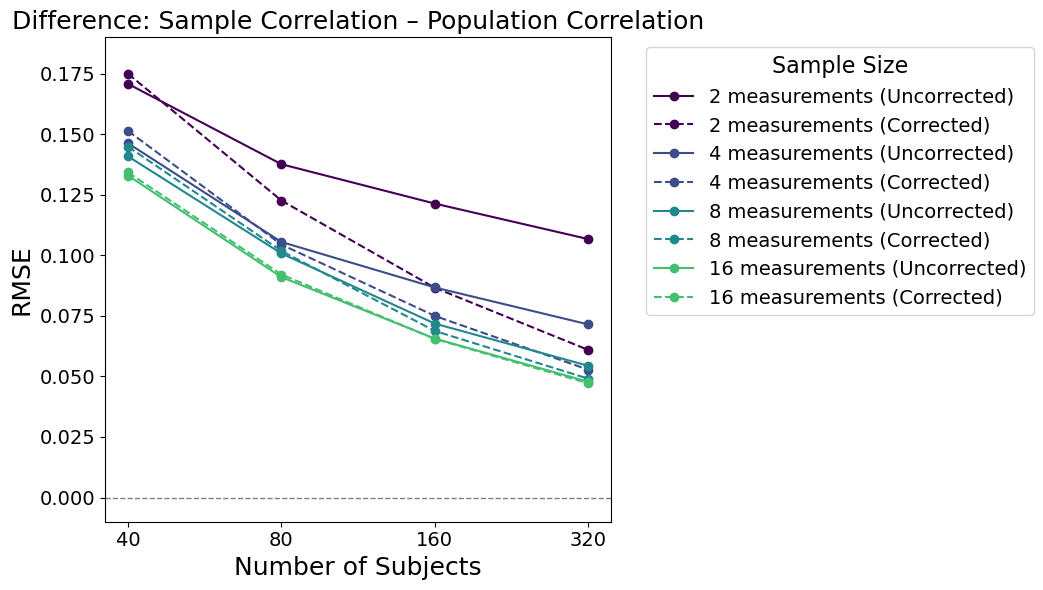

In [34]:
n_measurements = sorted(results_corr_df["n_measurements"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(n_measurements)))  # Use colormap for distinct colors

plt.figure(figsize=(10.7, 6))

for i, meas in enumerate(n_measurements):
    subset = results_corr_df[results_corr_df["n_measurements"] == meas]

    color = colors[i]
    plt.errorbar(subset["n_samples"], subset["rmse_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{meas} measurements (Uncorrected)")
    plt.errorbar(subset["n_samples"], subset["rmse_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{meas} measurements (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.yticks(size=14)
plt.ylim(-.01,0.19)
plt.xlabel("Number of Subjects", size=18)
plt.ylabel("RMSE", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([40, 80, 160, 320], labels=[40, 80, 160, 320], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

## Mean

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3752601241.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["meanDiff_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3752601241.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["meanDiff_corrected"],


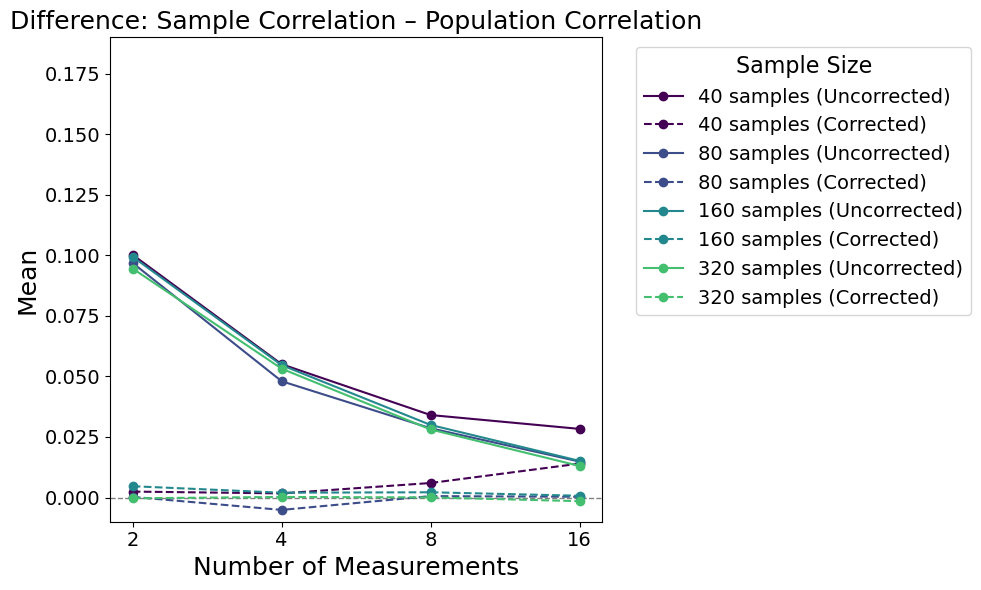

In [35]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors

plt.figure(figsize=(10, 6))

for i, sample_size in enumerate(sample_sizes):
    subset = results_corr_df[results_corr_df["n_samples"] == sample_size]

    color = colors[i]
    plt.errorbar(subset["n_measurements"], subset["meanDiff_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{sample_size} samples (Uncorrected)")
    plt.errorbar(subset["n_measurements"], subset["meanDiff_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{sample_size} samples (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim(-.01,0.19)
plt.xlabel("Number of Measurements", size=18)
plt.ylabel("Mean", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([2, 4, 8, 16], labels=[2, 4, 8, 16], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3202599748.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["meanDiff_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/3202599748.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["meanDiff_corrected"],


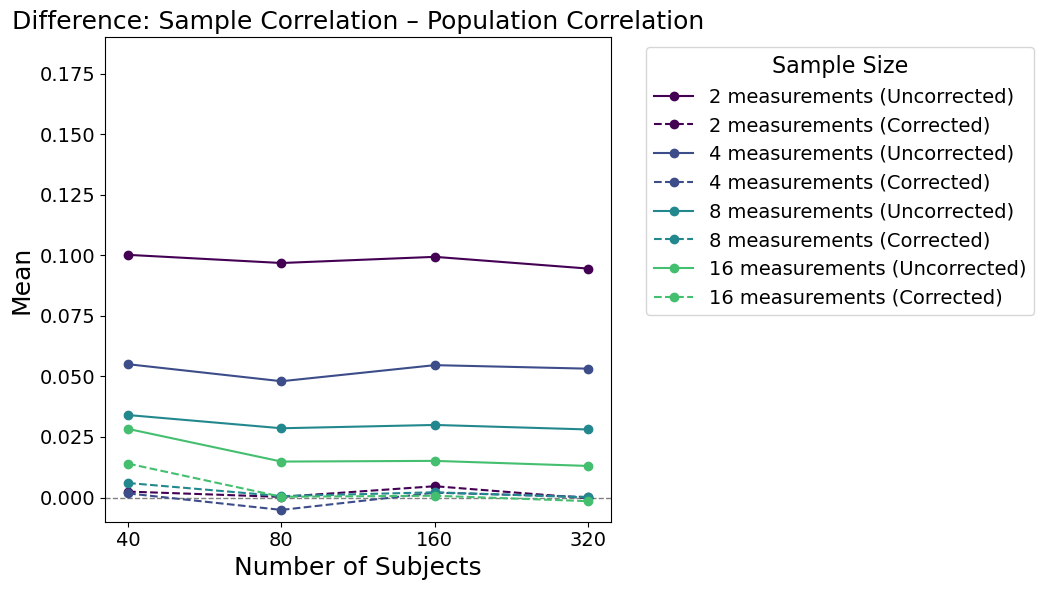

In [36]:
n_measurements = sorted(results_corr_df["n_measurements"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(n_measurements)))  # Use colormap for distinct colors

plt.figure(figsize=(10.7, 6))

for i, meas in enumerate(n_measurements):
    subset = results_corr_df[results_corr_df["n_measurements"] == meas]

    color = colors[i]
    plt.errorbar(subset["n_samples"], subset["meanDiff_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{meas} measurements (Uncorrected)")
    plt.errorbar(subset["n_samples"], subset["meanDiff_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{meas} measurements (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xticks(size=14)
plt.ylim(-.01,0.19)
plt.yticks(size=14)
plt.xlabel("Number of Subjects", size=18)
plt.ylabel("Mean", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([40, 80, 160, 320], labels=[40, 80, 160, 320], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

## SD

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/739137361.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["sd_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/739137361.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_measurements"], subset["sd_corrected"],


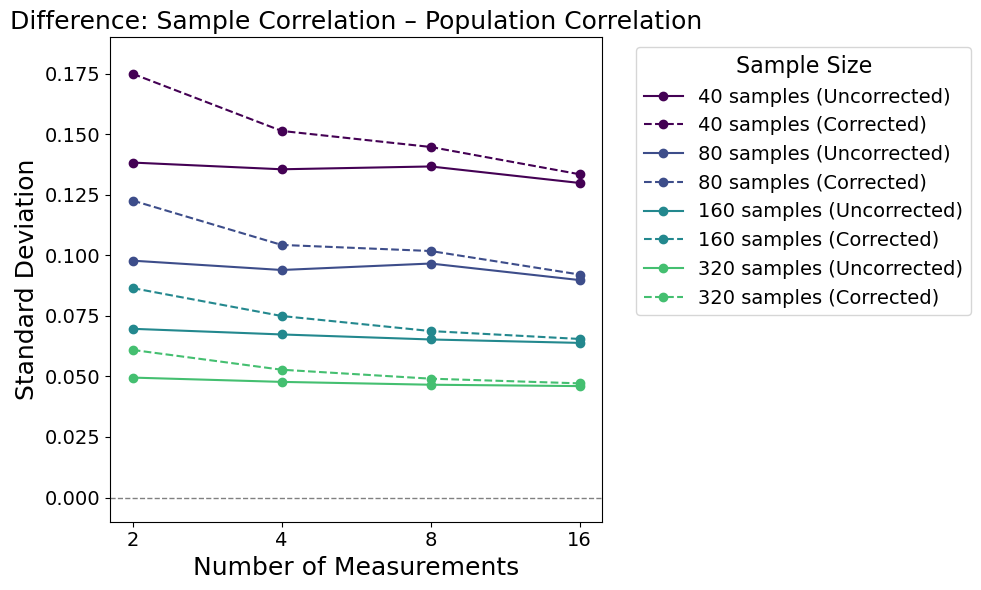

In [37]:
sample_sizes = sorted(results_corr_df["n_samples"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(sample_sizes)))  # Use colormap for distinct colors

plt.figure(figsize=(10, 6))

for i, sample_size in enumerate(sample_sizes):
    subset = results_corr_df[results_corr_df["n_samples"] == sample_size]

    color = colors[i]
    plt.errorbar(subset["n_measurements"], subset["sd_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{sample_size} samples (Uncorrected)")
    plt.errorbar(subset["n_measurements"], subset["sd_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{sample_size} samples (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.yticks(size=14)
plt.ylim(-.01,0.19)
plt.xlabel("Number of Measurements", size=18)
plt.ylabel("Standard Deviation", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([2, 4, 8, 16], labels=[2, 4, 8, 16], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/868788156.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["sd_measured"],
/var/folders/sk/b_2c8s2n1g1285l9s6dhhql80000gn/T/ipykernel_14936/868788156.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(subset["n_samples"], subset["sd_corrected"],


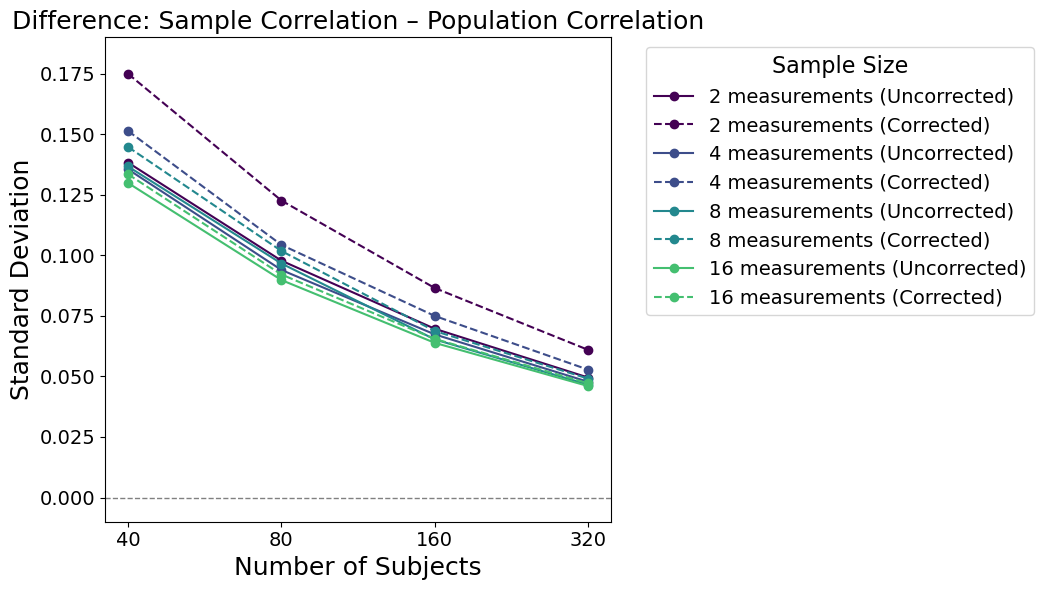

In [38]:
n_measurements = sorted(results_corr_df["n_measurements"].unique())
colors = plt.cm.viridis(np.linspace(0, .7, len(n_measurements)))  # Use colormap for distinct colors

plt.figure(figsize=(10.7, 6))

for i, meas in enumerate(n_measurements):
    subset = results_corr_df[results_corr_df["n_measurements"] == meas]

    color = colors[i]
    plt.errorbar(subset["n_samples"], subset["sd_measured"],
                 fmt='-o', linestyle='solid', color=color, label=f"{meas} measurements (Uncorrected)")
    plt.errorbar(subset["n_samples"], subset["sd_corrected"],
                 fmt='-o', linestyle='dashed', color=color, label=f"{meas} measurements (Corrected)")

plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim(-.01,0.19)
plt.xlabel("Number of Subjects", size=18)
plt.ylabel("Standard Deviation", size=18)
plt.title("Difference: Sample Correlation – Population Correlation", size = 18)
plt.xscale('log')
plt.xticks([40, 80, 160, 320], labels=[40, 80, 160, 320], size=14)
plt.gca().xaxis.set_minor_locator(plt.NullLocator())

# Keep only one legend entry per sample size
handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = list(dict.fromkeys(labels))  # Preserve order but remove duplicates
unique_handles = [handles[labels.index(label)] for label in unique_labels]

plt.legend(unique_handles, unique_labels, title="Sample Size", bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=16, fontsize=14)

plt.tight_layout()
plt.show()

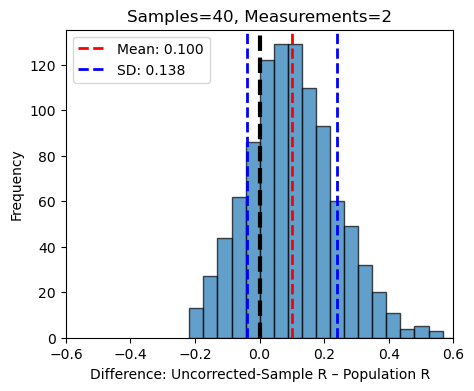

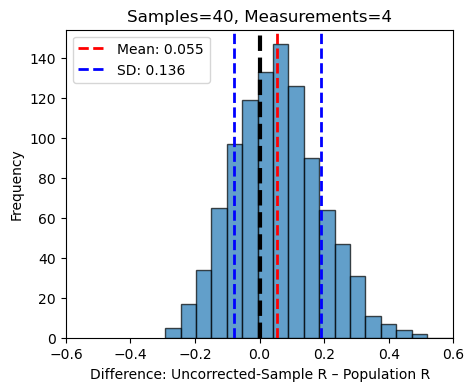

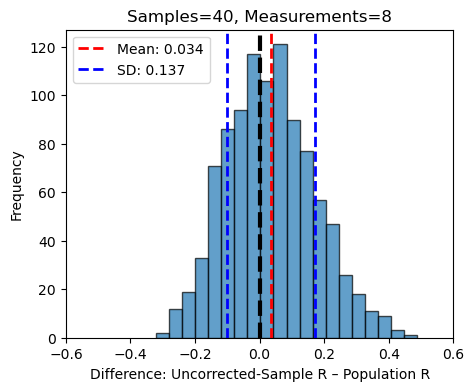

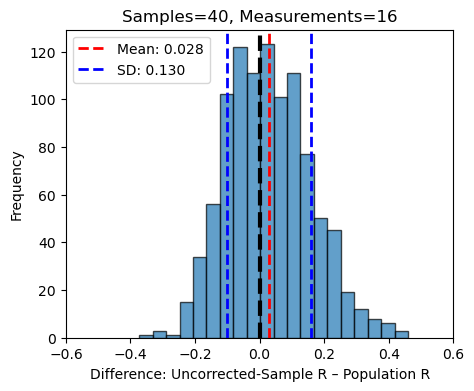

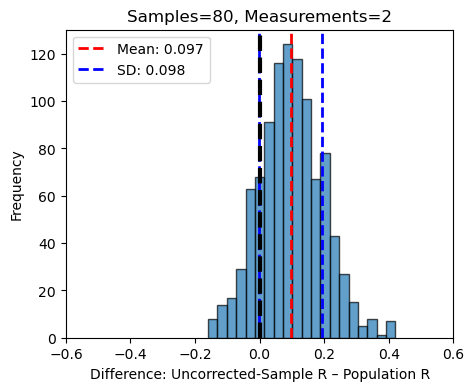

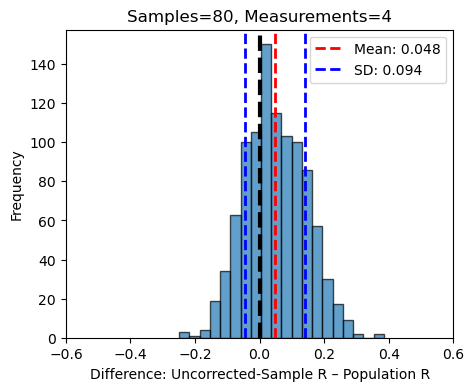

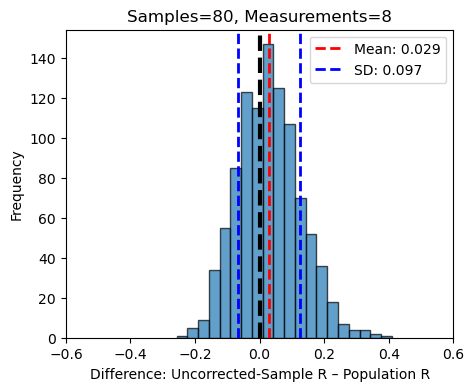

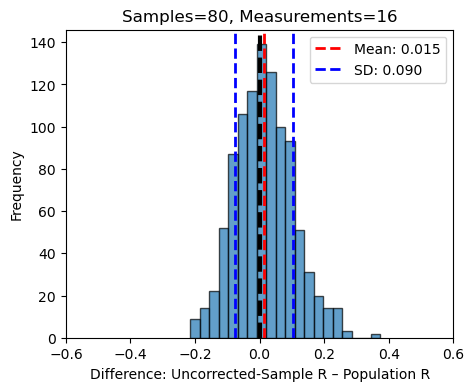

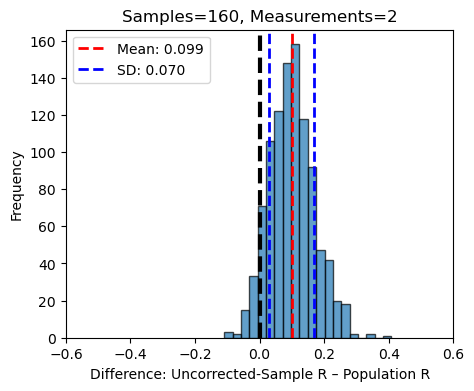

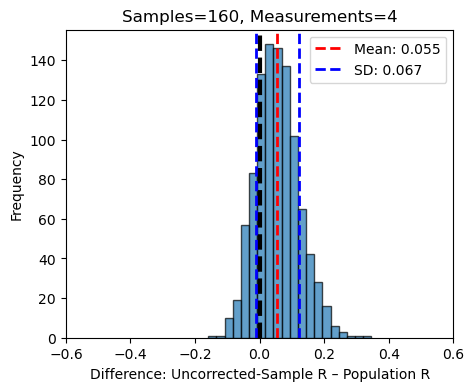

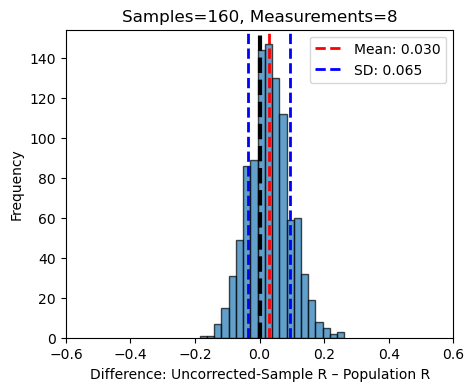

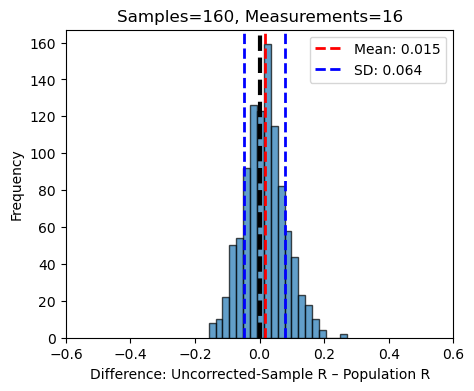

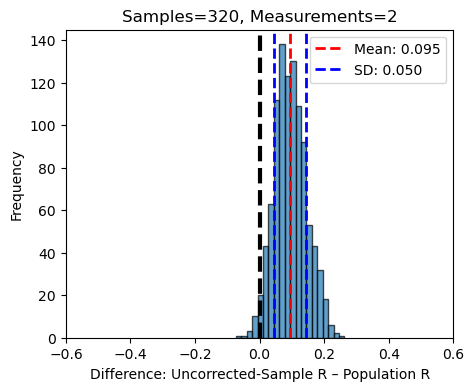

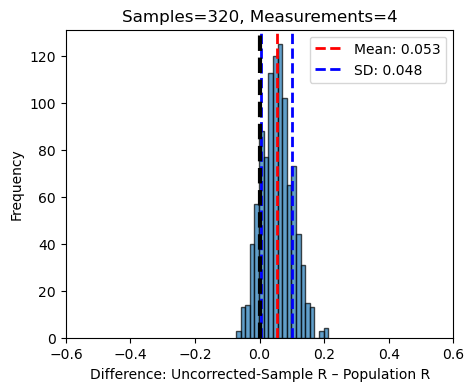

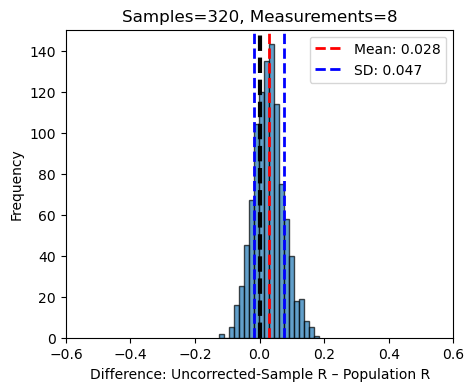

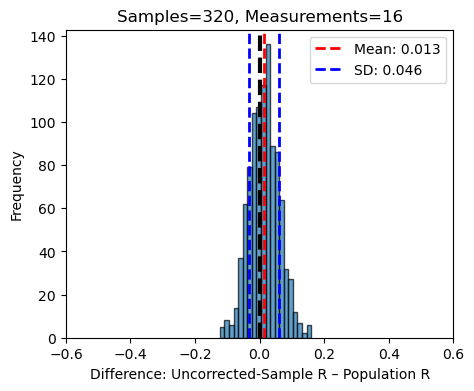

In [39]:
# Histograms – MEASURED
for (n_samples, n_measurements), differences in hist_measured_corr.items():
    mean_diff = np.mean(differences)
    sd = np.std(differences)

    plt.figure(figsize=(5, 4))
    plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
    plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
    plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
    plt.xlim(-.6,.6)
    plt.xlabel("Difference: Uncorrected-Sample R – Population R")
    plt.ylabel("Frequency")
    plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
    plt.legend()
    plt.show()

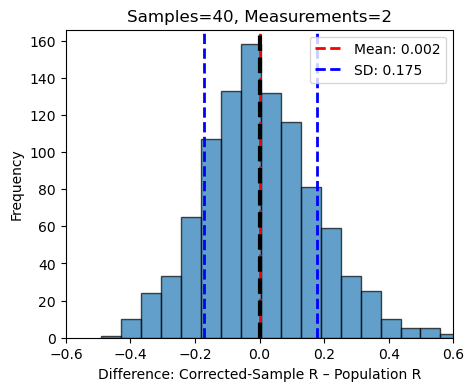

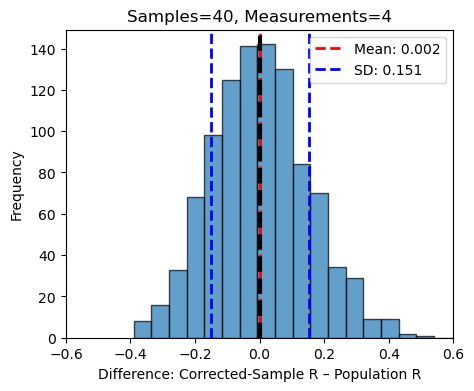

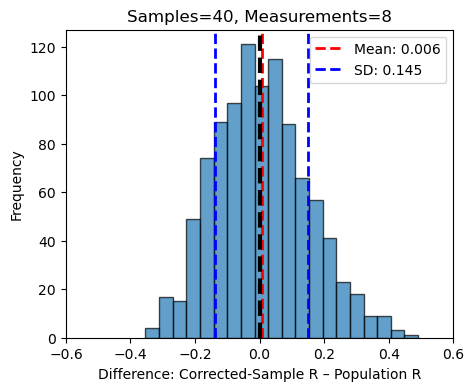

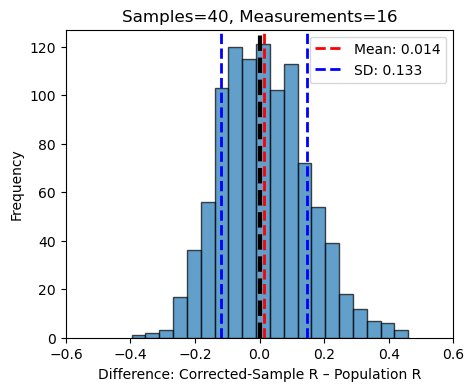

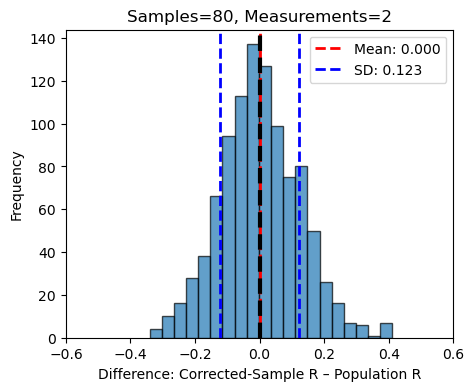

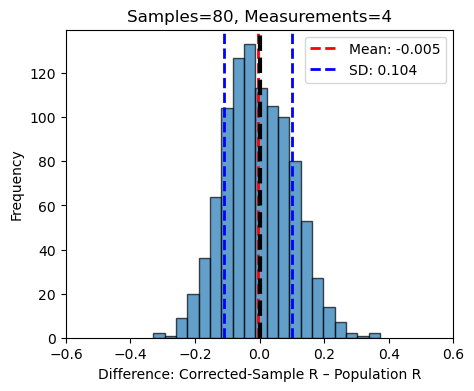

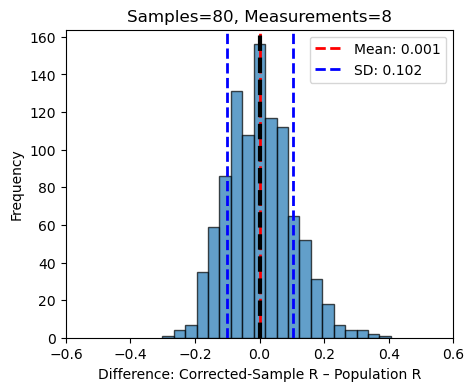

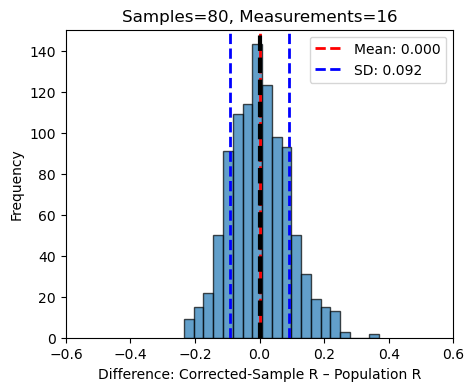

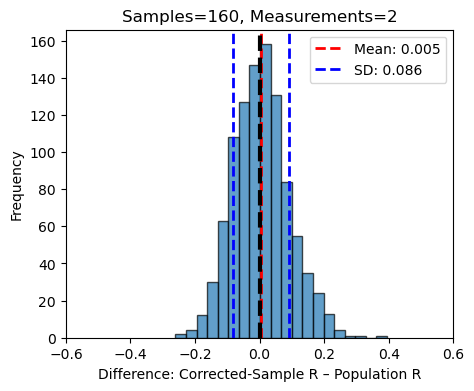

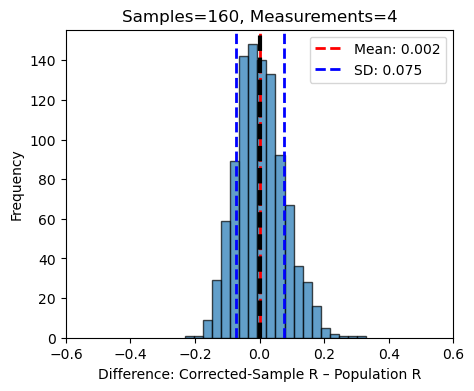

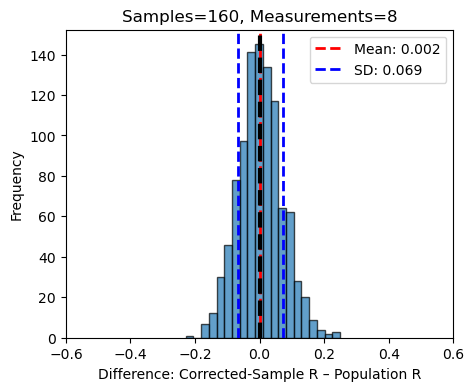

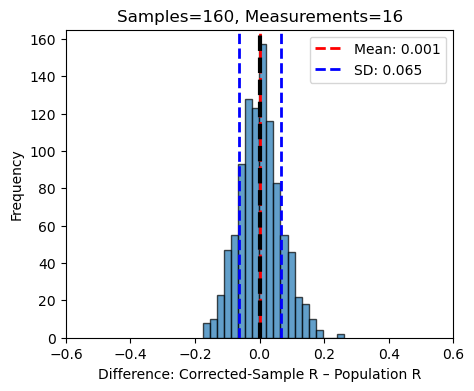

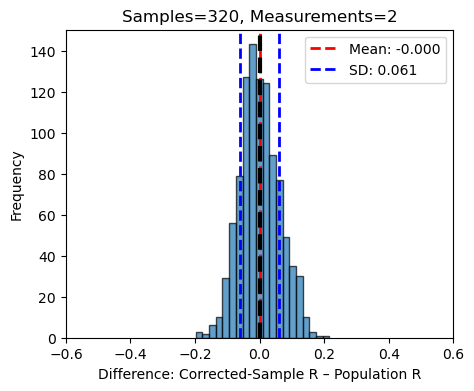

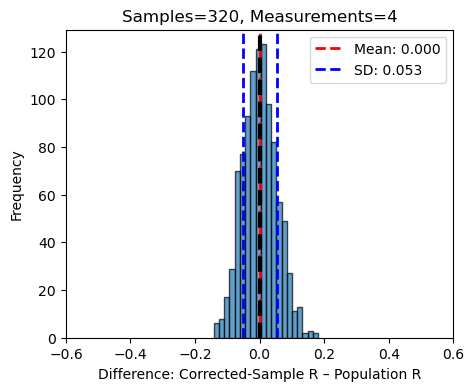

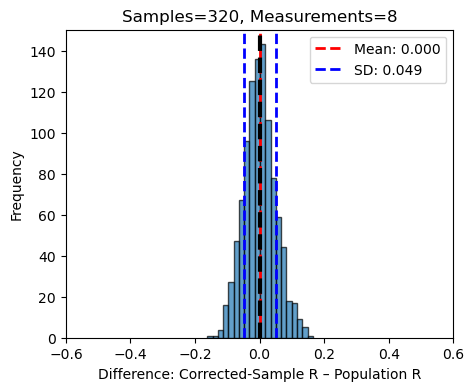

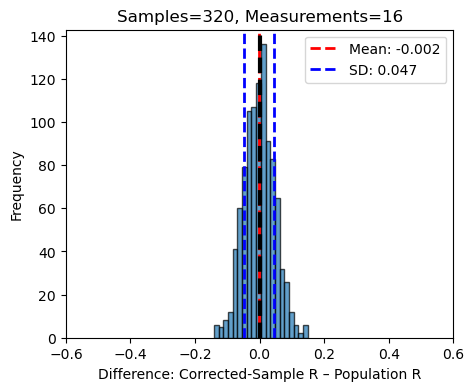

In [40]:
# Histograms – CORRECTED
for (n_samples, n_measurements), differences in hist_corrected_corr.items():
    mean_diff = np.mean(differences)
    sd = np.std(differences)

    plt.figure(figsize=(5, 4))
    plt.hist(differences, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(mean_diff, color='red', linestyle='dashed', linewidth=2, label=f"Mean: {mean_diff:.3f}")
    plt.axvline(mean_diff - sd, color='blue', linestyle='dashed', linewidth=2, label=f"SD: {sd:.3f}")
    plt.axvline(mean_diff + sd, color='blue', linestyle='dashed', linewidth=2)
    plt.axvline(0, color='black', linestyle='dashed', linewidth=3)
    plt.xlim(-.6,.6)
    plt.xlabel("Difference: Corrected-Sample R – Population R")
    plt.ylabel("Frequency")
    plt.title(f"Samples={n_samples}, Measurements={n_measurements}")
    plt.legend()
    plt.show()

## Scatterplots of simulated data

In [41]:
def plot_scatter(ax, x, y, x_name, y_name, title=None):
    """Plots scatterplot with regression line and Pearson correlation."""
    
    # Scatter plot
    ax.scatter(x, y, alpha=0.7)
    
    # Regression line
    # UPDATE TO MINIMIZE PRODUCT OF X AND Y RESIDUALS
    slope, intercept = np.polyfit(x, y, 1)
    x_vals = np.linspace(min(x), max(x), 100)
    y_vals = slope * x_vals + intercept
    #ax.plot(x_vals, y_vals, color='red', linestyle='dashed', label='Trend line')

    # Pearson correlation
    r, _ = stats.pearsonr(x, y)
    ax.text(0.05, 1.05, f'Pearson r = {r:.2f}', transform=ax.transAxes, fontsize=14, color='red')

    # Labels and title
    ax.set_xlabel(x_name, fontsize=14)
    ax.set_ylabel(y_name, fontsize=14)
    if title:
        ax.set_title(title)

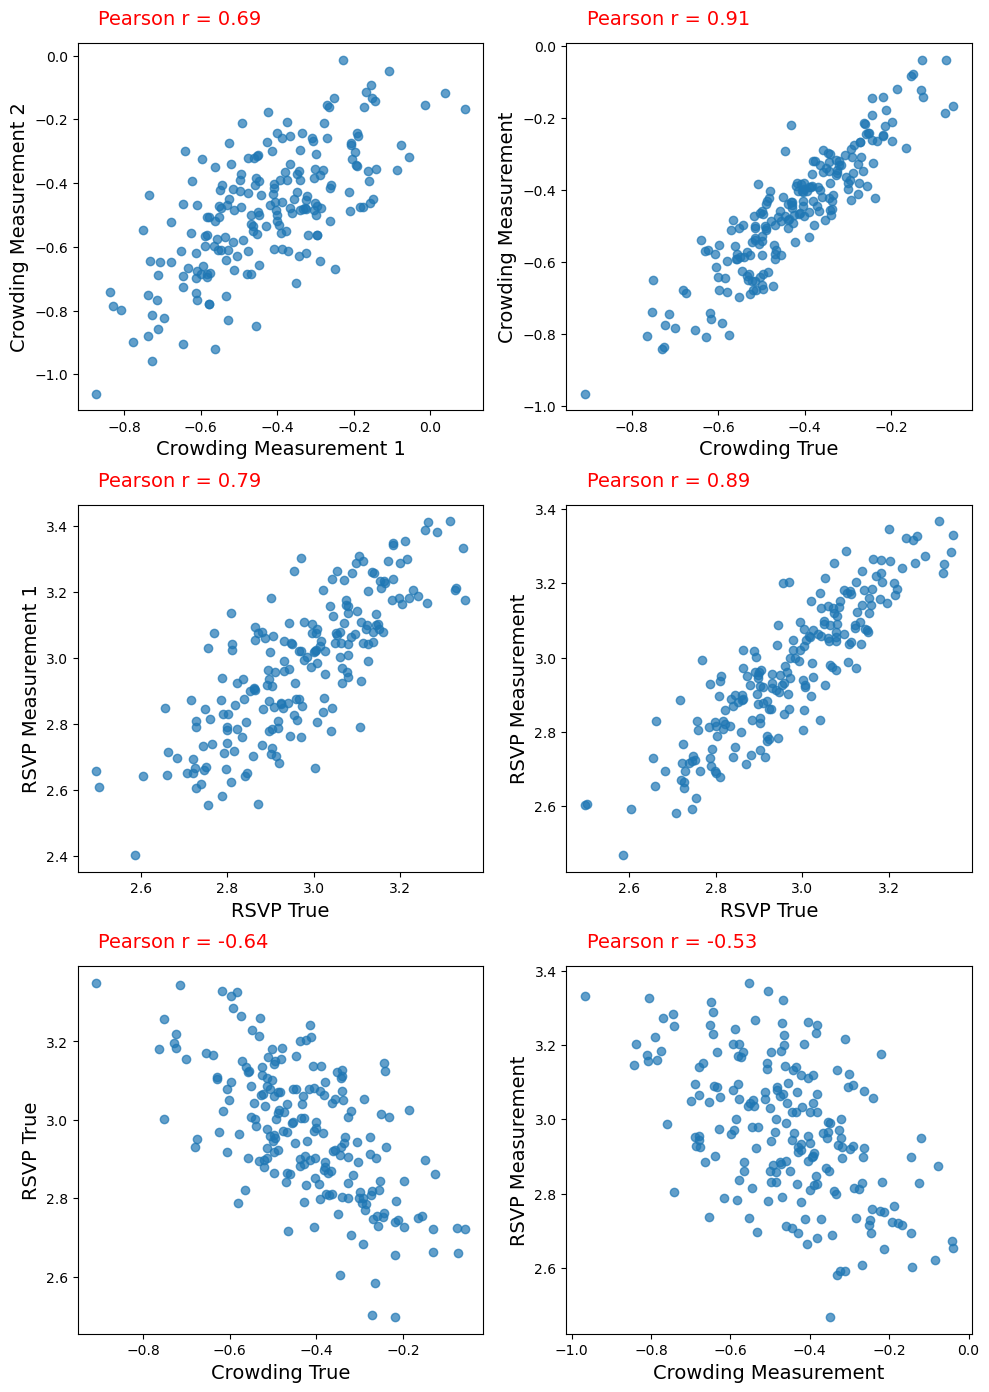

In [48]:
# Create a 3x2 grid of subplots
fig, axes = plt.subplots(3, 2, figsize=(10, 14))

# List of scatter plots (each tuple: x, y, x_label, y_label, title=None)
plot_data = [
    ('crowding_measurement1', 'crowding_measurement2', 'Crowding Measurement 1', 'Crowding Measurement 2'),
    ('crowding_true', 'crowding_measurement', 'Crowding True', 'Crowding Measurement'),
    ('rsvp_true', 'rsvp_measurement1', 'RSVP True', 'RSVP Measurement 1'),
    ('rsvp_true', 'rsvp_measurement', 'RSVP True', 'RSVP Measurement'),
    ('crowding_true', 'rsvp_true', 'Crowding True', 'RSVP True'),
    ('crowding_measurement', 'rsvp_measurement', 'Crowding Measurement', 'RSVP Measurement'),
]

# Loop through axes and data
for ax, (x_col, y_col, x_label, y_label) in zip(axes.flat, plot_data):
    plot_scatter(ax, simulation_data[x_col], simulation_data[y_col], x_label, y_label)

plt.tight_layout()
plt.show()


3D plot 
- x = number of blocks
- y = number of participants
- z = measured correlation

In [43]:
simulation_data = simulate_psychophysics_data(n_samples=100, n_measurements=6)
simulation_data = simulation_data[sorted(simulation_data.columns)]

crowding_1thru6 = simulation_data[['crowding_measurement1', 'crowding_measurement2', 'crowding_measurement3',
                                   'crowding_measurement4', 'crowding_measurement5', 'crowding_measurement6']]

rsvp_1thru6 = simulation_data[['rsvp_measurement1', 'rsvp_measurement2', 'rsvp_measurement3',
                               'rsvp_measurement4', 'rsvp_measurement5', 'rsvp_measurement6']]

for i in range(start + 2, start + 6):
    print(simulation_data.iloc[:,start:i].shape)
    # Variance within individuals: Variance across the 6 runs for each participant
    within_indiv_var[i-2] = np.mean(np.var(simulation_data.iloc[:,start:i], axis = 1, ddof=1))

measured_corr[i-2], _ = pearsonr(np.mean(simulation_data, axis=1), np.mean(y, axis=1))

NameError: name 'start' is not defined

In [ ]:
# Below I compute variances within and across individuals for different selections of 
# our 6 repeats, ranging from repeat #1-2, #1-3, #1-4, and so on
# to see how these variances change as we accumulate data

within_indiv_var = np.full((len(range(2, 7))), np.nan)
across_indiv_var = np.full((len(range(2, 7))), np.nan)

start = 1   # index of first crowding measurement column

for i in range(start + 2, start + 6):
    print(simulation_data.iloc[:,start:i].shape)
    # Variance within individuals: Variance across the 6 runs for each participant
    within_indiv_var[i-2] = np.mean(np.var(simulation_data.iloc[:,start:i], axis = 1, ddof=1))

    # Variance across individuals: Variance across participants for each run
    across_indiv_var[i-2] = np.var(np.mean(simulation_data.iloc[:,start:i], axis=1), ddof=1)
    

# Plot variances for subj_right
variances = np.arange(2, within_indiv_var.shape[0] + 2)

plt.figure(figsize=(10, 6))
plt.plot(variances, within_indiv_var, marker='o', label='within participant')
plt.plot(variances, across_indiv_var, marker='o', label='across participant')
plt.title('Crowding', fontsize = 16)
plt.xlabel('Number of repeats included in var', fontsize = 14)
plt.ylabel('Standard deviation', fontsize = 14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.yscale('log')
#plt.ylim([0.2,2])

plt.show()

In [ ]:
# Below I compute variances within and across individuals for different selections of 
# our 6 repeats, ranging from repeat #1-2, #1-3, #1-4, and so on
# to see how these variances change as we accumulate data

within_indiv_var = np.full((len(range(2, 7))), np.nan)
across_indiv_var = np.full((len(range(2, 7))), np.nan)

start = 9   # index of first RSVP measurement column

for i in range(start + 2, start + 6):
    print(simulation_data.iloc[:,start:i].shape)
    # Variance within individuals: Variance across the 6 runs for each participant
    within_indiv_var[i-start-1] = np.mean(np.var(simulation_data.iloc[:,start:i], axis = 1, ddof=1))

    # Variance across individuals: Variance across participants for each run
    across_indiv_var[i-start-1] = np.var(np.mean(simulation_data.iloc[:,start:i], axis=1), ddof=1)
    

# Plot variances for subj_right
variances = np.arange(2, within_indiv_var.shape[0] + 2)

plt.figure(figsize=(10, 6))
plt.plot(variances, within_indiv_var, marker='o', label='within participant')
plt.plot(variances, across_indiv_var, marker='o', label='across participant')
plt.title('RSVP', fontsize = 16)
plt.xlabel('Number of repeats included in var', fontsize = 14)
plt.ylabel('Variance', fontsize = 14)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
#plt.yscale('log')
#plt.ylim([0.2,2])

plt.show()

\begin{aligned}
    \hspace{-12em}\text{Derivation of noise-corrected correlation formula:} \\[2em]
    &\hspace{-8em} X' = X + M \quad \text{(e.g., measured crowding distance)} \\[1em]
    &\hspace{-8em} X \sim \mathcal{N}(0, \text{varX}), \quad M \sim \mathcal{N}(0, \text{varM}) \\[3em]
    &\hspace{-8em} Y' = Y + N \quad \text{(e.g., measured reading speed)} \\[1em]
    &\hspace{-8em} Y \sim \mathcal{N}(0, \text{varY}), \quad N \sim \mathcal{N}(0, \text{varN}) \\[3em]
    \hspace{-14em}\text{Measured correlation:} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{cov}(X', Y')}{\sqrt{\text{varX}' \cdot \text{varY}'}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{mean}((X' - \text{mean}(X')) \cdot (Y' - \text{mean}(Y')))}{\sqrt{\text{varX}' \cdot \text{varY}'}} \\[2em]
    \hspace{-14em}\text{Expanding terms:} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{mean}(X' \cdot Y')}{\sqrt{(\text{varX} + \text{varM}) \cdot (\text{varY} + \text{varN})}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{mean}((X + M) \cdot (Y + N))}{\sqrt{(\text{varX} + \text{varM}) \cdot (\text{varY} + \text{varN})}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{mean}(X \cdot Y + X \cdot N + M \cdot Y + M \cdot N)}{\sqrt{(\text{varX} + \text{varM}) \cdot (\text{varY} + \text{varN})}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{cov}(X, Y)}{\sqrt{(\text{varX} + \text{varM}) \cdot (\text{varY} + \text{varN})}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{corr}(X, Y) \cdot \sqrt{\text{varX} \cdot \text{varY}}}{\sqrt{(\text{varX} + \text{varM}) \cdot (\text{varY} + \text{varN})}} \\[1em]
    &\hspace{-8em} \text{corr}(X', Y') = \frac{\text{corr}(X, Y)}{\sqrt{(1 + r_X) \cdot (1 + r_Y)}} \\[3em]
    \hspace{-14em} \text{Where:} \\[1em]
    &\hspace{-8em} r_X = \frac{\text{varM}}{\text{varX}}, \quad r_Y = \frac{\text{varN}}{\text{varY}} \\[3em]
    \hspace{-14em}\text{Final expression:} \\[1em]
    &\hspace{-8em} \rho' = \frac{\rho}{\sqrt{(1 + r_X) \cdot (1 + r_Y)}}
\end{aligned}


In [ ]:
# SIMULATED DATA

# Define X as the mean of the test and retest crowding simulations (2 measurements)
# and Y as mean of the test and retest RSVP simulations (2 measurements)
X = simulation_data['crowding_measurement']
Y = simulation_data['rsvp_measurement']

# Compute measurement variances for crowding and reading using simulated test-retest measurements
varM = np.var(simulation_data['crowding_measurement2'] - simulation_data['crowding_measurement1'], ddof=1) / 2
varN = np.var(simulation_data['rsvp_measurement2'] - simulation_data['rsvp_measurement1'], ddof=1) / 2

# Compute "true" crowding and RSVP variances by adjusting for measurement variance
varX = np.var(X, ddof=1) - varM
varY = np.var(Y, ddof=1) - varN

# Compute ratios
rX = varM / varX
rY = varN / varY

# Compute measured correlation of crowding with RSVP
measured_corr, _ = pearsonr(X, Y)

# Compute noise-adjusted ("true") correlation
true_corr = measured_corr * np.sqrt((1 + rX) * (1 + rY))

# Print results
print(f"Measured Correlation: {measured_corr.round(4)}")
print(f"True Correlation: {true_corr.round(4)}")

In [ ]:
# PRE-VSS EXPERIMENT DATA

# Define X as the mean of right- and left-meridian test and retest (4 measurements)
# and Y as mean RSVP reading test-retest (2 measurements)
X = df['crowding']
Y = df['rsvp']

# Compute measurement variances for crowding and RSVP using test-retest measurements
varM = np.var(df['crowding_test'] - df['crowding_retest'], ddof=1) / 4
varN = np.var(df['rsvp_foveal_test'] - df['rsvp_foveal_retest'], ddof=1) / 2

# Compute "true" crowding and RSVP variances by adjusting for measurement variance
varX = np.var(X, ddof=1) - varM
varY = np.var(Y, ddof=1) - varN

# Compute ratios
rX = varM / varX
rY = varN / varY

# Compute measured correlation of crowding with RSVP
measured_corr, _ = pearsonr(X, Y)

# Compute noise-adjusted ("true") correlation
true_corr = measured_corr * np.sqrt((1 + rX) * (1 + rY))

# Print results
print(f"Measured Correlation: {measured_corr.round(4)}")
print(f"True Correlation: {true_corr.round(4)}")

In [ ]:
# PRE-VSS EXPERIMENT DATA

# Define X as the mean of right-meridian test-retest (2 measurements)
# and Y as mean RSVP reading test-retest (2 measurements)
X = df['crowding_R']
Y = df['rsvp']

# Compute measurement variances for crowding and RSVP using test-retest measurements
varM = np.var(df['crowding_R5_test'] - df['crowding_R5_retest'], ddof=1) / 2
varN = np.var(df['rsvp_foveal_test'] - df['rsvp_foveal_retest'], ddof=1) / 2

# Compute "true" crowding and RSVP variances by adjusting for measurement variance
varX = np.var(X, ddof=1) - varM
varY = np.var(Y, ddof=1) - varN

# Compute ratios
rX = varM / varX
rY = varN / varY

# Compute measured correlation of crowding with RSVP
measured_corr, _ = pearsonr(X, Y)

# Compute noise-adjusted ("true") correlation
true_corr = measured_corr * np.sqrt((1 + rX) * (1 + rY))

# Print results
print(f"Measured Correlation: {measured_corr.round(4)}")
print(f"True Correlation: {true_corr.round(4)}")